### In this notebook, we'll use integrated gradients to explain a sequence model for text classification.
Based entirely on the paper https://arxiv.org/pdf/1703.01365.pdf

---



In [53]:
#@title Library imports.
import os
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, rgb2hex
import pandas as pd
from IPython.display import HTML


pd.set_option('display.max_colwidth', 150)


In [55]:
#@title Download dataset and build training set.

def convert_ds_to_tuple(sample):
  """See output DataFrame to get a sense of the columns."""
  return sample['description'], sample['label']


# download the ag_news_subset dataset; https://www.tensorflow.org/datasets/catalog/ag_news_subset
# split them into train/val/test, train:val = 90:10
(raw_train_ds, raw_val_ds, raw_test_ds), info = tfds.load('ag_news_subset',
                                                          split=['train[:90%]',
                                                                 'train[-90%:]',
                                                                 'test'],
                                                          with_info=True)
_LABEL_NAMES = info.features['label'].names
print(f"Labels: {_LABEL_NAMES}")

batch_size = 128

# DataFrame for nice output.
train_sample_df = \
    tfds.as_dataframe(raw_train_ds.shuffle(batch_size).take(5),
                      ds_info=info)[['description', 'label']]
train_sample_df['topic'] = \
    train_sample_df['label'].apply(lambda x: _LABEL_NAMES[x])

# Convert dataframe into dataset.
raw_train_ds = raw_train_ds.map(convert_ds_to_tuple).batch(batch_size)
raw_val_ds = raw_val_ds.map(convert_ds_to_tuple).batch(batch_size)
raw_test_ds = raw_test_ds.map(convert_ds_to_tuple).batch(batch_size)
train_sample_df

Labels: ['World', 'Sports', 'Business', 'Sci/Tech']


,description,label,topic
0,"b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'",3,Sci/Tech
1,b'An Islamic militant group has claimed on its website to have killed 11 Iraqi national guardsmen it kidnapped near Baghdad last week.',0,World
2,"b'Despite all the Bond touches, the latest in the Metal Gear Solid series keeps its belly on the ground and does pretty much everything right. Gam...",3,Sci/Tech
3,"b'A car is overturned in a damaged Route 117 in Ojiya, northwest of Tokyo, Sunday, Oct. 24, 2004. A barrage of powerful quakes jolted the region S...",0,World
4,"b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial t...",3,Sci/Tech


In [56]:
#@title Build a sequence model to predict the news topic for given text: Pre-processing / Text Vectorization

# build the tokenizer layer first
vocab_size = 1000
e_dim = 64
n_classes = info.features['label'].num_classes
pre_processing_layer = TextVectorization(max_tokens=vocab_size,
                                         output_sequence_length=50,
                                         name='Preprocessing_layer')

# fit the training set to the layer
pre_processing_layer.adapt(raw_train_ds.map(lambda x, y: x))
# store the vocab
vocab = pre_processing_layer.get_vocabulary()

# vectorize the text inputs
@tf.autograph.experimental.do_not_convert
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return pre_processing_layer(text), label

# tokenize all datasets and prepare for training
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Print an example input document vector.
text_batch, label_batch = next(iter(raw_train_ds.shuffle(50)))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", _LABEL_NAMES[first_label])
print("Vectorized text", vectorize_text(first_review, first_label))

Review:  tf.Tensor(b'Manager Graeme Souness has stunned the football world by turning his back on Blackburn Rovers to become the new manager of Newcastle United.', shape=(), dtype=string)
Label:  Sports
Vectorized review (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[427,   1,   1,  20,   1,   2, 302,  51,  18,   1,  24, 117,   8,
          1,   1,   4, 468,   2,  21, 427,   5,   1,  72,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [57]:
#@title Build a sequence model to predict the news topic for given text: Bi-directional LSTM model.
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=e_dim,
                              name='embedding',
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax', name='probs')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 probs (Dense)               (None, 4)                 68        
                                                                 
Total params: 89,940
Trainable params: 89,940
Non-trainable params: 0
_________________________________________________________________


In [58]:
#@title Build a sequence model to predict the news topic for given text: Model training.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)
model.evaluate(test_ds, verbose=2)

Epoch 1/5
844/844 [==============================] - 52s 47ms/step - loss: 0.5437 - sparse_categorical_accuracy: 0.7840 - val_loss: 0.3941 - val_sparse_categorical_accuracy: 0.8603
Epoch 2/5
844/844 [==============================] - 17s 21ms/step - loss: 0.4019 - sparse_categorical_accuracy: 0.8545 - val_loss: 0.3790 - val_sparse_categorical_accuracy: 0.8650
Epoch 3/5
844/844 [==============================] - 18s 22ms/step - loss: 0.3873 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.3652 - val_sparse_categorical_accuracy: 0.8686
Epoch 4/5
844/844 [==============================] - 17s 21ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.3525 - val_sparse_categorical_accuracy: 0.8722
Epoch 5/5
844/844 [==============================] - 20s 23ms/step - loss: 0.3602 - sparse_categorical_accuracy: 0.8681 - val_loss: 0.3386 - val_sparse_categorical_accuracy: 0.8764
60/60 - 1s - loss: 0.3923 - sparse_categorical_accuracy: 0.8568 - 655ms/epoch - 11ms/step


[0.39228373765945435, 0.8568421006202698]

60/60 [==============================] - 5s 13ms/step


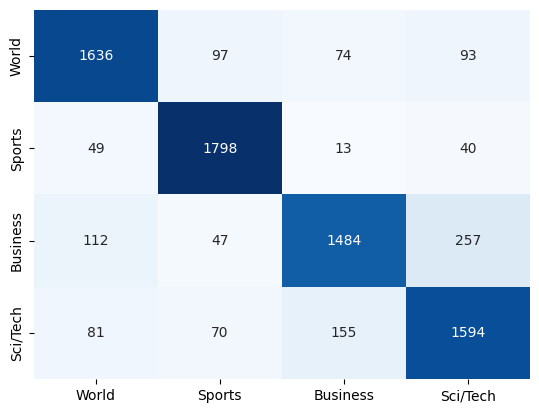

In [59]:
#@title Build a sequence model to predict the news topic for given text: Model evaluation on test set.

test_probs = model.predict(test_ds)
test_preds = tf.argmax(test_probs, axis=1)
test_labels = \
    test_ds.flat_map(lambda x, y:
                     tf.data.Dataset.from_tensor_slices(y)).as_numpy_iterator()
test_labels = tf.convert_to_tensor(list(test_labels), dtype=test_preds.dtype)
cm = tf.math.confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=_LABEL_NAMES,
            yticklabels=_LABEL_NAMES, cbar=False)
plt.show()

In [86]:
#@title Explaining the model: implement path-integrated-gradients from scratch.

# Based on https://arxiv.org/pdf/1703.01365.pdf

# Important note: embedding lookup layer is not differentiable. So we will get
# the embedding layer out and build the rest of the model as a new_model to
# explain.

embed_layer = model.get_layer('embedding')
new_model = tf.keras.Sequential()
for layer in model.layers[1:]:
    new_model.add(layer)


def interpolate_texts(baseline, text, m_steps=50):
    """Raw inputs interpolated between [0, ..., 0] to text"""
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    delta = text - baseline
    texts = baseline + alphas_x * delta
    return texts

def compute_gradients(t, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(t)
        probs = new_model(t)[:, target_class_idx]
    grads = tape.gradient(probs, t)
    return grads

In [89]:
#@title Explaining the model: choose samples from test set to predict and explain.
# Samples from test dataset that we will explain from.
sample_vectors = next(test_ds.take(1).as_numpy_iterator())[0]
sample_texts = next(raw_test_ds.take(1).as_numpy_iterator())[0]
sample_labels = next(test_ds.take(1).as_numpy_iterator())[1]
[(idx, _LABEL_NAMES[sample_label]) for idx, sample_label in enumerate(sample_labels)]


[(0, 'Sports'),
 (1, 'World'),
 (2, 'Sci/Tech'),
 (3, 'Sports'),
 (4, 'World'),
 (5, 'Sci/Tech'),
 (6, 'Sports'),
 (7, 'Sports'),
 (8, 'World'),
 (9, 'Business'),
 (10, 'World'),
 (11, 'Sci/Tech'),
 (12, 'Business'),
 (13, 'World'),
 (14, 'World'),
 (15, 'Sports'),
 (16, 'Sports'),
 (17, 'Sci/Tech'),
 (18, 'Business'),
 (19, 'World'),
 (20, 'Business'),
 (21, 'Sci/Tech'),
 (22, 'World'),
 (23, 'Business'),
 (24, 'Sci/Tech'),
 (25, 'World'),
 (26, 'Sci/Tech'),
 (27, 'World'),
 (28, 'Business'),
 (29, 'World'),
 (30, 'Sci/Tech'),
 (31, 'Sci/Tech'),
 (32, 'Business'),
 (33, 'Sci/Tech'),
 (34, 'Business'),
 (35, 'Sci/Tech'),
 (36, 'World'),
 (37, 'Sci/Tech'),
 (38, 'Sports'),
 (39, 'Sci/Tech'),
 (40, 'World'),
 (41, 'Business'),
 (42, 'World'),
 (43, 'Sports'),
 (44, 'Business'),
 (45, 'Sports'),
 (46, 'World'),
 (47, 'Sports'),
 (48, 'Business'),
 (49, 'Sci/Tech'),
 (50, 'World'),
 (51, 'Sci/Tech'),
 (52, 'Sports'),
 (53, 'Business'),
 (54, 'Sports'),
 (55, 'Sci/Tech'),
 (56, 'Business'),

In [91]:
#@title Explaining the model: choose an example to predict and explain.

# Generate a random sample to explain.
index = tf.cast(tf.random.uniform(shape=[1],
                                  minval=sample_vectors.shape[0]),
                dtype=tf.int8).numpy()[0]
sample_text = sample_texts[index]
sample_vector = sample_vectors[index]
sample_label = sample_labels[index]
# get embeddings
sample_embed = embed_layer(sample_vector)
# Create a Baseline vector with zero embeddings
baseline_embed = tf.zeros(shape=tf.shape(sample_embed))
# get preds for sample
sample_preds = model(sample_vectors)[index]
# print the results with color codes
words = [vocab[i] for i in sample_vector]
print("Text that we will predict on, and explain:\n\t" + " ".join(words))
print(f"True Label: {_LABEL_NAMES[sample_label]}")
print(f"Predicted Label: "
      f"{_LABEL_NAMES[tf.argmax(sample_preds).numpy()]}")

Text that we will predict on, and explain:
	[UNK] [UNK] sports network [UNK] [UNK] running back [UNK] [UNK] will [UNK] the [UNK] of the season after being [UNK] on injured reserve saturday                          
True Label: Sports
Predicted Label: Sports


In [92]:
#@title Explaining the model: run path integrated gradients on chosen example.

# Shape of interpolated_texts is:
# (num_interpolations, seq_len, embed_dim)
interpolated_texts = interpolate_texts(baseline_embed,
                                       sample_embed)
# We will use the sample_label,
# we could use the argmax of the predicted label too.
target_label = sample_label # target_label = 2
path_gradients = compute_gradients(interpolated_texts, target_label)

# sum the grads of the interpolated vectors
all_grads = tf.reduce_sum(path_gradients, axis=0) / 50
# mulitply grads by (input - baseline); baseline is zero vectors
x_grads = tf.math.multiply(all_grads, sample_embed)
# sum all gradients across the embedding dimension
igs = tf.reduce_sum(x_grads, axis=-1).numpy()
igs

array([ 0.01503567,  0.00951594,  0.585492  ,  0.04791806,  0.00839702,
        0.00771074,  0.12669863,  0.08726814,  0.00857167,  0.00859937,
        0.0452485 ,  0.00903757,  0.02222231,  0.00916978, -0.03345826,
        0.02799248,  0.32904336,  0.00628255,  0.05651209,  0.00840228,
        0.02304166, -0.0586144 , -0.03237599, -0.01450913, -0.02901262,
       -0.02841164, -0.02763817, -0.02683578, -0.02601073, -0.02515788,
       -0.02427566, -0.02336648, -0.02243602, -0.02149162, -0.02054083,
       -0.01959039, -0.01864573, -0.01771067, -0.01678715, -0.01587475,
       -0.01497041, -0.01406854, -0.01316183, -0.01224302, -0.01130759,
       -0.01035765, -0.00940669, -0.00848116, -0.00760047, -0.00802505],
      dtype=float32)

In [93]:
#@title Explaining the model: visualize the feature attributions.

# Visualization code taken from:
# https://docs.seldon.io/projects/alibi/en/stable/examples/integrated_gradients_imdb.html

def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"


def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """

    cmap_bound = tf.reduce_max(tf.abs(attrs))
    norm = Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.colormaps.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: rgb2hex(cmap(norm(x))), attrs))
    return colors

colors = colorize(igs)
print(f"Sample Text: {str(sample_text)}\n")
# print(f"Sample Vector: {sample_vector}")

print("Predictions : ")
for index in tf.argsort(sample_preds,
                        axis=-1, direction='DESCENDING').numpy():
    print(f"\t{_LABEL_NAMES[index]} --> {sample_preds[index]*100:0.2f}%")

print(f"\nTrue Label: {_LABEL_NAMES[sample_label]}")
print(f"\nAttributions for Label: {_LABEL_NAMES[target_label]}")
print(f"\nTop 5 Important words: "
      f"{[words[i] for i in tf.argsort(igs, -1, 'DESCENDING')[:5]]}\n")
HTML("".join(list(map(hlstr, words, colors))))

Sample Text: b' CHARLOTTE, N.C. (Sports Network) - Carolina Panthers  running back Stephen Davis will miss the remainder of the  season after being placed on injured reserve Saturday.'

Predictions : 
	Sports --> 99.87%
	World --> 0.12%
	Business --> 0.01%
	Sci/Tech --> 0.00%

True Label: Sports

Attributions for Label: Sports

Top 5 Important words: ['sports', 'season', 'running', 'back', 'being']

